In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr

In [3]:
BASE_DIR = "/Users/akshatha/GeorgakopoulosSoaresLab/g4_analysis"
G4_PATH = f"{BASE_DIR}/results/g4hunter_g4_distribution.csv"
    
# set color map for domains
color_map = {
    'Virus': '#66c2a5',
    'Bacteria': '#fc8d62',
    'Eukaryota': '#8da0cb',
    'Archaea': '#e78ac3'
}

def get_domain(taxa):
    if taxa == 'viral':
        return 'Virus'
    elif taxa == 'bacteria':
        return 'Bacteria'
    elif taxa == 'archaea':
        return 'Archaea'
    else:
        return 'Eukaryota'

In [4]:
# read species data
df_species = pd.read_csv(f"{BASE_DIR}/results/species_data.csv")
df_species = df_species[["Accession", "Genome Size", "GC Percentage", "Taxa"]]
df_species = df_species.replace('na', np.nan)
df_species["GC Percentage"] = df_species["GC Percentage"].astype(float)
df_species["Genome Size"] = df_species["Genome Size"].astype(float)
df_species["Domain"] = df_species["Taxa"].apply(get_domain)
df_species.head()

,Accession,Genome Size,GC Percentage,Taxa,Domain
0,GCA_000002515.1,10689156.0,38.5,fungi,Eukaryota
1,GCA_031844645.1,6733472.0,61.0,bacteria,Bacteria
2,GCA_958295725.1,3665566.0,67.0,bacteria,Bacteria
3,GCA_000002765.3,23292622.0,19.0,protozoa,Eukaryota
4,GCA_000006645.1,4701745.0,47.5,bacteria,Bacteria


In [5]:
# read g4 data
df_g4 = pd.read_csv(G4_PATH)
df_g4 = df_g4[["accession", "g4_count", "total_g4_length"]]
df_g4 = df_g4.rename(columns={"accession": "Accession"})
df_g4["g4_count"] = df_g4["g4_count"].astype(float)
df_g4["total_g4_length"] = df_g4["total_g4_length"].astype(float)
# merge with species data
df_g4 = pd.merge(df_g4, df_species, on="Accession")
df_g4["G4 Density (per Mb)"] = df_g4["g4_count"] / df_g4["Genome Size"] * 1000000
df_g4.head()

# remove metagenomes and other taxa
df_g4 = df_g4[df_g4['Taxa'] != 'metagenomes']
df_g4 = df_g4[df_g4['Taxa'] != 'other']

[  14.01867668 -441.06331155]


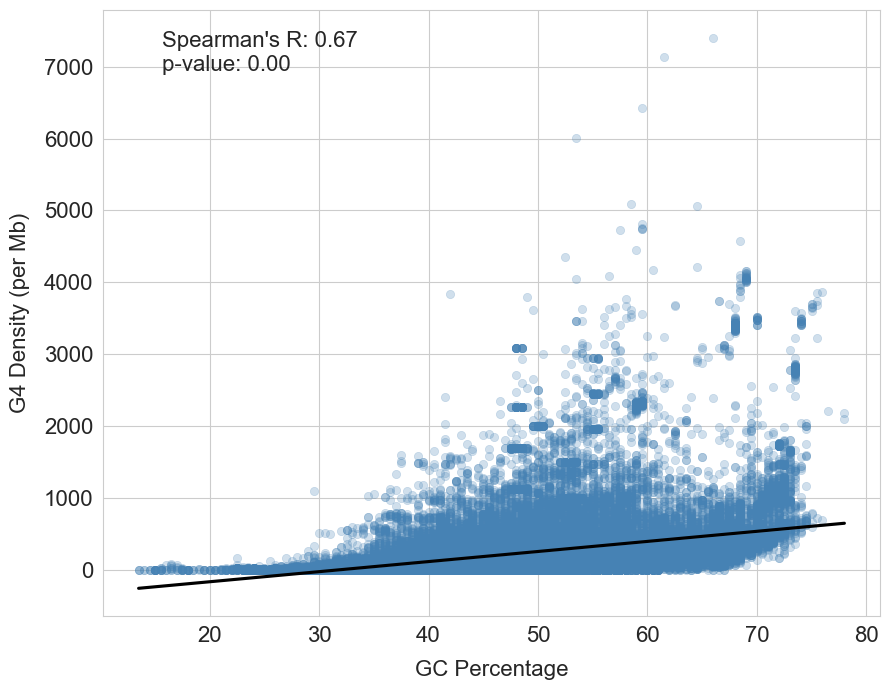

In [6]:
# scatter plot of G4 density vs GC percentage
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(9, 7))
sns.scatterplot(
    x="GC Percentage", 
    y="G4 Density (per Mb)", 
    alpha=0.25, 
    color='steelblue', 
    edgecolor='steelblue', 
    data=df_g4, 
    ax=ax
)
sns.regplot(
    data=df_g4,
    x="GC Percentage",
    y="G4 Density (per Mb)", 
    scatter=False,
    color='black', 
    ax=ax
)
# formatting
plt.xlabel("GC Percentage", fontsize=16, labelpad=10)
plt.ylabel("G4 Density (per Mb)", fontsize=16, labelpad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.ticklabel_format(style='plain')
plt.tight_layout()

# display spearman correlation coefficient
corr, p = spearmanr(df_g4['GC Percentage'], df_g4['G4 Density (per Mb)'])
ax.text(0.075, 0.9, f"Spearman's R: {corr:.2f}\np-value: {p:.2f}", transform=ax.transAxes, fontsize=16)

# save figure
plt.savefig(f"{BASE_DIR}/plots/g4_density_vs_gc_content_g4hunter.png")

# display slope and intercept
print(np.polyfit(df_g4['GC Percentage'], df_g4['G4 Density (per Mb)'], 1))

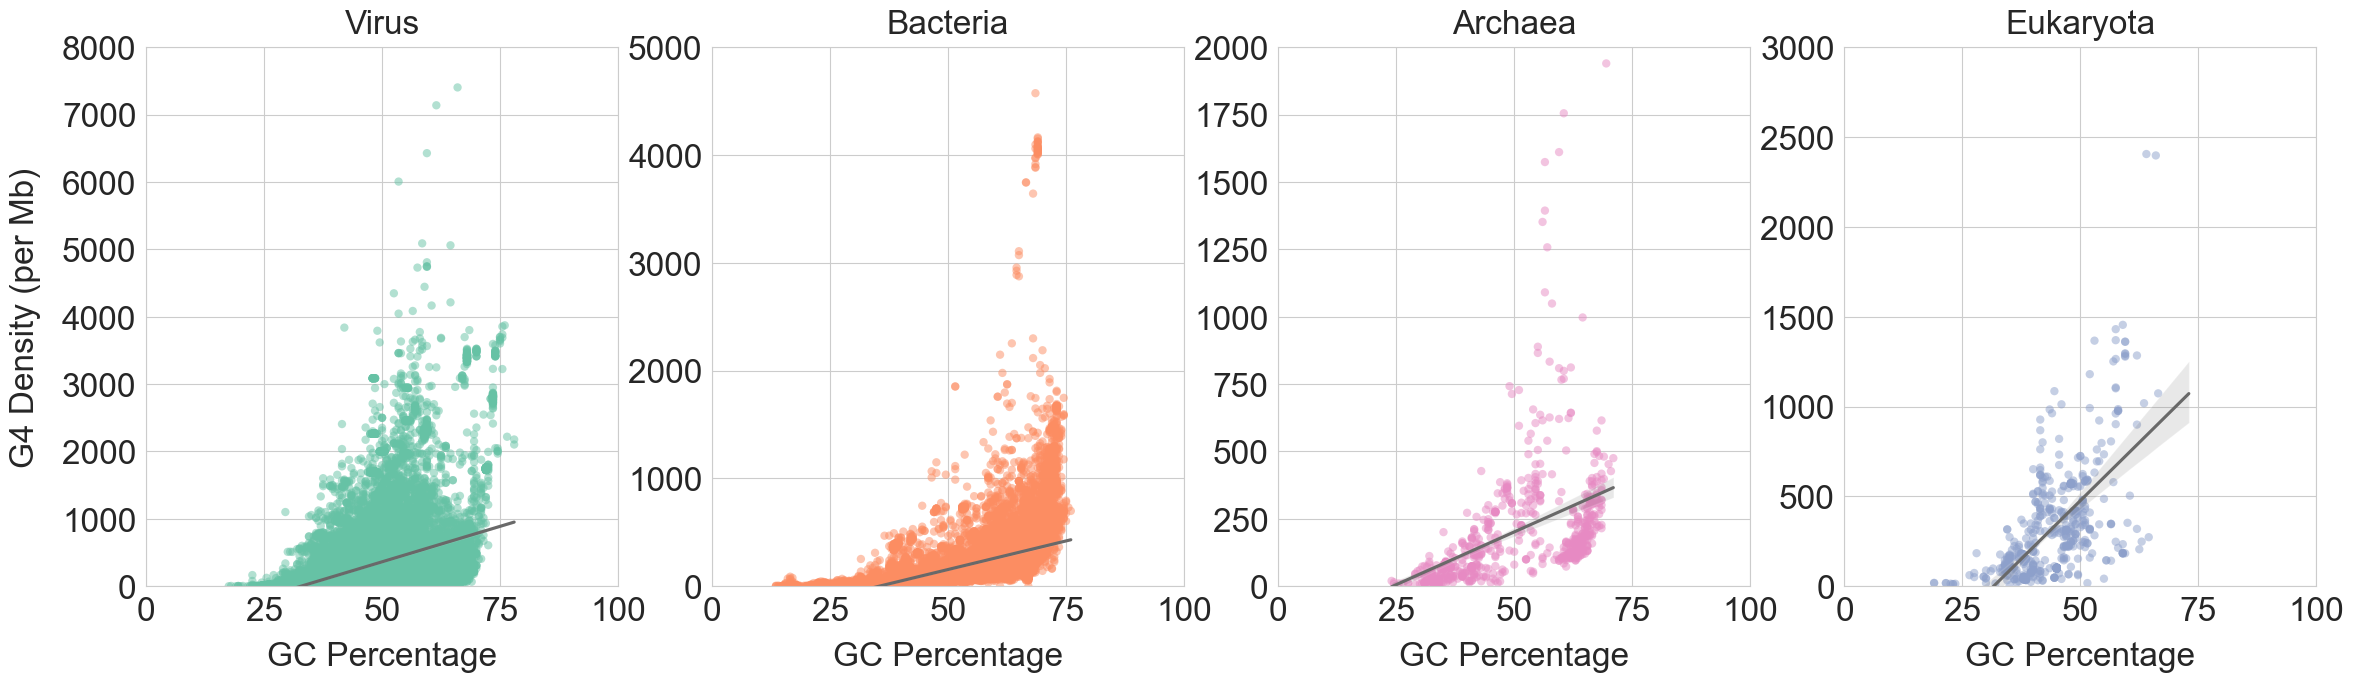

In [7]:
# plot the distribution of GC Percentage vs G4 density (per Mb) for each domain
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 4, figsize=(28, 7))
sns.scatterplot(
    data=df_g4[df_g4['Domain'] == 'Virus'],
    x="GC Percentage",
    y="G4 Density (per Mb)",
    alpha=0.5, edgecolor='none',
    ax=ax[0],
    color=color_map['Virus']
)
sns.regplot(
    data=df_g4[df_g4['Domain'] == 'Virus'],
    x="GC Percentage",
    y="G4 Density (per Mb)",
    ax=ax[0],
    scatter=False,
    color='dimgrey'
)
sns.scatterplot(
    data=df_g4[df_g4['Domain'] == 'Bacteria'],
    x="GC Percentage",
    y="G4 Density (per Mb)",
    alpha=0.5, edgecolor='none',
    ax=ax[1],
    color=color_map['Bacteria']
)
sns.regplot(
    data=df_g4[df_g4['Domain'] == 'Bacteria'],
    x="GC Percentage",
    y="G4 Density (per Mb)",
    ax=ax[1],
    scatter=False,
    color='dimgrey'
)
sns.scatterplot(
    data=df_g4[df_g4['Domain'] == 'Archaea'],
    x="GC Percentage",
    y="G4 Density (per Mb)",
    ax=ax[2],
    alpha=0.5, edgecolor='none',
    color=color_map['Archaea']
)
sns.regplot(
    data=df_g4[df_g4['Domain'] == 'Archaea'],
    x="GC Percentage",
    y="G4 Density (per Mb)",
    ax=ax[2],
    scatter=False,
    color='dimgrey'
)
sns.scatterplot(
    data=df_g4[df_g4['Domain'] == 'Eukaryota'],
    x="GC Percentage",
    y="G4 Density (per Mb)",
    ax=ax[3],
    alpha=0.5, edgecolor='none',
    color=color_map['Eukaryota']
)
sns.regplot(
    data=df_g4[df_g4['Domain'] == 'Eukaryota'],
    x="GC Percentage",
    y="G4 Density (per Mb)",
    ax=ax[3],
    scatter=False,
    color='dimgrey'
)

# set title for each subplot
ax[0].set_title('Virus', fontsize=24, pad=10)
ax[1].set_title('Bacteria', fontsize=24, pad=10)
ax[2].set_title('Archaea', fontsize=24, pad=10)
ax[3].set_title('Eukaryota', fontsize=24, pad=10)

# set axis labels for each subplot
ax[0].set_xlabel('GC Percentage', fontsize=24, labelpad=10)
ax[1].set_xlabel('GC Percentage', fontsize=24, labelpad=10)
ax[2].set_xlabel('GC Percentage', fontsize=24, labelpad=10)
ax[3].set_xlabel('GC Percentage', fontsize=24, labelpad=10)

# set y label only for leftmost subplot
ax[0].set_ylabel('G4 Density (per Mb)', fontsize=24, labelpad=15)
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[3].set_ylabel('')

# specify x axis limits for each subplot
ax[0].set_xlim(0, 100)
ax[1].set_xlim(0, 100)
ax[2].set_xlim(0, 100)
ax[3].set_xlim(0, 100)

# specify y axis lower limit for each subplot
ax[0].set_ylim(0, 8000)
ax[1].set_ylim(0, 5000)
ax[2].set_ylim(0, 2000)
ax[3].set_ylim(0, 3000)

# set tick font size
ax[0].tick_params(axis='both', which='major', labelsize=24)
ax[1].tick_params(axis='both', which='major', labelsize=24)
ax[2].tick_params(axis='both', which='major', labelsize=24)
ax[3].tick_params(axis='both', which='major', labelsize=24)

plt.savefig(f"{BASE_DIR}/plots/gc_percentage_g4_density_domain_g4hunter.png")

In [8]:
# get correlation coefficient and p-values for each domain
virus_data = df_g4[df_g4['Domain'] == 'Virus']
bacteria_data = df_g4[df_g4['Domain'] == 'Bacteria']
archaea_data = df_g4[df_g4['Domain'] == 'Archaea']
eukaryota_data = df_g4[df_g4['Domain'] == 'Eukaryota']

print(spearmanr(virus_data['GC Percentage'], virus_data['G4 Density (per Mb)']))
print(spearmanr(bacteria_data['GC Percentage'], bacteria_data['G4 Density (per Mb)']))
print(spearmanr(archaea_data['GC Percentage'], archaea_data['G4 Density (per Mb)']))
print(spearmanr(eukaryota_data['GC Percentage'], eukaryota_data['G4 Density (per Mb)']))

# display slope and intercept
print(np.polyfit(virus_data['GC Percentage'], virus_data['G4 Density (per Mb)'], 1))
print(np.polyfit(bacteria_data['GC Percentage'], bacteria_data['G4 Density (per Mb)'], 1))
print(np.polyfit(archaea_data['GC Percentage'], archaea_data['G4 Density (per Mb)'], 1))
print(np.polyfit(eukaryota_data['GC Percentage'], eukaryota_data['G4 Density (per Mb)'], 1))

SignificanceResult(statistic=0.6139337853669848, pvalue=0.0)
SignificanceResult(statistic=0.8856168594462868, pvalue=0.0)
SignificanceResult(statistic=0.7048207153720946, pvalue=1.639033777544186e-97)
SignificanceResult(statistic=0.6097547177910624, pvalue=1.1475335795241637e-54)
[  21.05902509 -690.54926013]
[  10.60475767 -374.89588029]
[   7.82428072 -189.67942348]
[  25.90896596 -819.14363645]
